In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import anndata as ad
from datetime import datetime
import scipy

import anndata2ri

from utils import simulate_patient_counts

In [2]:
# Activate the anndata2ri conversion between SingleCellExperiment and AnnData
anndata2ri.activate()

#Loading the rpy2 extension enables cell magic to be used
#This runs R code in jupyter notebook cells
%load_ext rpy2.ipython

sc.settings.verbosity = 3

In [3]:
%%R

# load Nick's Seurat object
suppressPackageStartupMessages(library(Seurat))

load("/localdata/rna_rep_learning/data.CD45P.3.Robj")

#update to new version of Seurat
cd45_updated <- CreateSeuratObject(counts = obj@raw.data, meta.data = obj@meta.data)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

R[write to console]: Warning:
R[write to console]:  Feature names cannot have underscores ('_'), replacing with dashes ('-')



In [4]:
%%R -o cd45_adata
#convert the Seurat object to a SingleCellExperiment object
cd45_adata <- as.SingleCellExperiment(cd45_updated)

cd45_adata

/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/anndata2ri/r2py.py:106: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return AnnData(exprs, obs, var, uns, obsm or None, layers=layers)


class: SingleCellExperiment 
dim: 23776 19027 
metadata(0):
assays(2): X logcounts
rownames(23776): RP11-34P13.7 RP11-34P13.8 ... AC233755.1 AC240274.1
rowData names(0):
colnames(19027): AACTCTTCATGGATGG-3 AACTTTCCAGTACACT-3 ...
  TGAGCATGTGGTAACG-75 GACCTGGCAATCCGAT-78
colData names(23): orig.ident nCount_RNA ... patient.bc ident
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/anndata2ri/r2py.py:106: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return AnnData(exprs, obs, var, uns, obsm or None, layers=layers)


In [5]:
cd45_adata

AnnData object with n_obs × n_vars = 19027 × 23776
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nGene', 'nUMI', 'samp.no', 'sample', 'patient', 'mark', 'percent.mito', 'disease', 'IgType', 'batch', 'vial', 'disease.long', 'pct.IG', 'res.0.6', 'full.cluster', 'res.1.4', 'clust1.4', 'cell.type', 'patient.bc', 'ident'
    layers: 'logcounts'

In [6]:
def norm_counts(counts, lib_sizes=None):
    """
    normalize gene counts to fractions, so that each cells sums to 1
    
    counts: a cells x genes count matrix
    lib_sizes: (optional) a vector of library sizes per cell, in the same order as counts
    """
    if scipy.sparse.issparse(counts):
        counts = counts.todense()
    if lib_sizes is None:
        lib_sizes = np.sum(counts, axis=1)
    if not isinstance(lib_sizes, np.ndarray):
        lib_sizes = lib_sizes.to_numpy()
    #make broadcastable with counts
    lib_sizes = lib_sizes.reshape(-1,1)
   
    #divide each value by library size of cell
    norm_counts = np.divide(counts, lib_sizes)
    
    return norm_counts

In [7]:
norm_counts = norm_counts(counts = cd45_adata.X, lib_sizes = cd45_adata.obs.nCount_RNA)

(array([1.5935e+04, 1.7350e+03, 8.5400e+02, 3.2800e+02, 9.6000e+01,
        4.5000e+01, 2.5000e+01, 6.0000e+00, 0.0000e+00, 3.0000e+00]),
 array([ 0.        ,  2.62812089,  5.25624179,  7.88436268, 10.51248357,
        13.14060447, 15.76872536, 18.39684625, 21.02496715, 23.65308804,
        26.28120894]),
 <BarContainer object of 10 artists>)

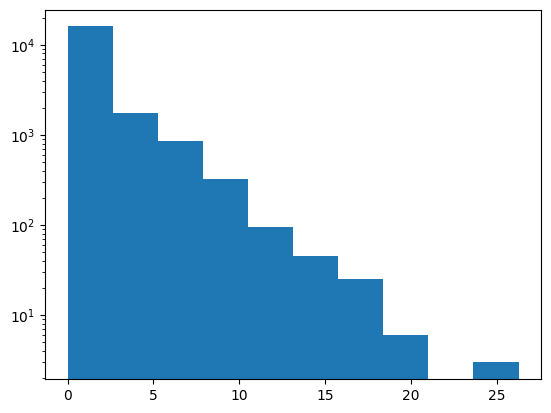

In [8]:
#plot and examine the distributions for some genes
#unnormalized
plt.hist(norm_counts[:,50]*10000, log=True)

In [9]:
cd45_adata.obs.rename(columns={"cell.type": "celltype"}, inplace=True)

In [10]:
from scipy.stats import gamma
gamma.fit(norm_counts[cd45_adata.obs.celltype=="B-cells"][:,50]*10000)

(0.42843699117539813, -2.4331644409325494e-29, 4.306833036049831)

In [11]:
r = gamma.rvs(0.42843699117539813, -2.4331644409325494e-29, 4.306833036049831, size=1000)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


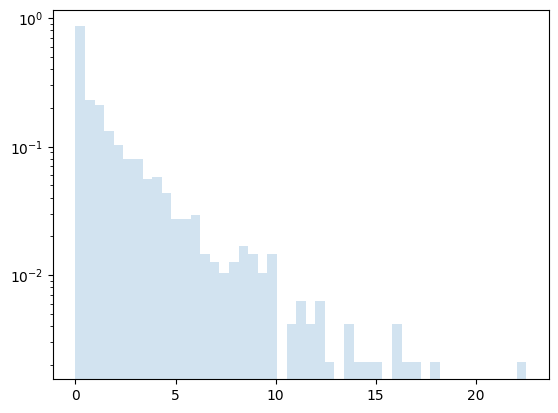

In [12]:
fig, ax = plt.subplots(1, 1)
ax.hist(r, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
ax.legend(loc='best', frameon=False)
plt.yscale("log")
plt.show()

In [13]:
def fit_gamma_per_gene(norm_counts, genes=None):
    """
    returns tuple of (shape, loc, and scale) parameters of a Gamma fitted to each gene
    
    norm_counts: counts normalized to library size per cell
    genes: (optional) a subset of genes to fit. default is all genes
    """
    if genes is not None:
        raise NotImplementedError("haven't yet implemented passing in subset of genes")
    
    #handle genes that are 0 everywhere
    gene_sums = norm_counts.sum(axis=0)
    
    params = list()
    for g in np.arange(norm_counts.shape[1]):
        if gene_sums[:,g].item()==0:
            params.append((None, None, None))
        else:
            params.append(scipy.stats.gamma.fit(norm_counts[:,g]))
        if g % 1000 == 0:
            print("fit {}/{} genes".format(g, norm_counts.shape[1]))
        
    return params

In [ ]:
Bcell_gene_gamma_params = fit_gamma_per_gene(norm_counts[cd45_adata.obs.celltype=="B-cells"]) #takes ~15 minutes

In [ ]:
Bcell_gene_params_df = pd.DataFrame(Bcell_gene_gamma_params, columns=["a", "location", "scale"])
Bcell_gene_params_df

In [ ]:
Tcell_gene_gamma_params = fit_gamma_per_gene(norm_counts[cd45_adata.obs.celltype=="T-cells"]) #takes ~15 minutes

In [ ]:
cd14monocyte_gene_gamma_params = fit_gamma_per_gene(norm_counts[cd45_adata.obs.celltype=="CD14+ Monocytes"]) #takes ~15 minutes

In [ ]:
gene_params={"T-cell":pd.DataFrame(Tcell_gene_gamma_params, columns=["a", "location", "scale"]), 
             "B-cell":pd.DataFrame(Bcell_gene_gamma_params, columns=["a", "location", "scale"]), 
             "monocytes":pd.DataFrame(cd14monocyte_gene_gamma_params, columns=["a", "location", "scale"])}

In [ ]:
file = open('normed_celltyespecific_geneparams.obj', 'wb')
pickle.dump(gene_params,file)
file.close()

In [14]:
with open('normed_celltyespecific_geneparams.obj', 'rb') as f:
    gene_params = pickle.load(f)

In [ ]:
def estimate_global_sample_params(adata):
    
    return(mean_ncells, l_mu, l_sigma2)

#### what fraction of each cell type should we use?

In [15]:
# compare variance on fractions of cell types in real patients and across synthetic samples

# fraction of the 3 cell types in real patients?
real_pt_cell_fracs = pd.DataFrame(cd45_adata.obs[cd45_adata.obs.celltype.isin(['T-cells','B-cells','CD14+ Monocytes'])][['patient','celltype']].groupby('patient').value_counts(normalize=True)).reset_index()
real_pt_cell_fracs.rename(columns={0:'frac'}, inplace=True)
real_pt_cell_fracs.head()


,patient,celltype,frac
0,NBM-1,CD14+ Monocytes,0.531646
1,NBM-1,T-cells,0.430380
2,NBM-1,B-cells,0.037975
3,NBM-2,T-cells,0.572890
4,NBM-2,CD14+ Monocytes,0.268542


In [16]:
print(real_pt_cell_fracs[real_pt_cell_fracs.celltype=="T-cells"].frac.mean())
print(real_pt_cell_fracs[real_pt_cell_fracs.celltype=="B-cells"].frac.mean())
print(real_pt_cell_fracs[real_pt_cell_fracs.celltype=="CD14+ Monocytes"].frac.mean())

0.650569474163637
0.0653823225585179
0.2840482032778452


In [ ]:
cell_type_probs={"T-cell":0.65, "B-cell":0.065, "monocytes":0.284}
print([cell_type_probs[i] for i in cell_types])

In [ ]:
sim_cell_fracs.head()

In [ ]:
plt.hist(sim_cell_fracs[sim_cell_fracs.celltype=="T-cell"].frac, alpha=0.5, label="sim");
plt.hist(real_pt_cell_fracs[real_pt_cell_fracs.celltype=="T-cells"].frac, alpha=0.5, label="real");
plt.legend()

In [ ]:
plt.hist(sim_cell_fracs[sim_cell_fracs.celltype=="B-cell"].frac, alpha=0.5, label="sim");
plt.hist(real_pt_cell_fracs[real_pt_cell_fracs.celltype=="B-cells"].frac, alpha=0.5, label="real");
plt.legend()

In [ ]:
plt.hist(sim_cell_fracs[sim_cell_fracs.celltype=="monocytes"].frac, alpha=0.5, label="sim");
plt.hist(real_pt_cell_fracs[real_pt_cell_fracs.celltype=="CD14+ Monocytes"].frac, alpha=0.5, label="real");
plt.legend()

In [ ]:
# how many T/B/mono per patient in the real dataset? use that as mean_ncells
cd45_adata.obs[cd45_adata.obs.celltype.isin(['T-cells','B-cells','CD14+ Monocytes'])].groupby('patient').size().mean()

In [ ]:
# what is fraction of the 3 cell types in real patients?
print(real_pt_cell_fracs[real_pt_cell_fracs.celltype=="T-cells"].frac.mean())
print(real_pt_cell_fracs[real_pt_cell_fracs.celltype=="B-cells"].frac.mean())
print(real_pt_cell_fracs[real_pt_cell_fracs.celltype=="CD14+ Monocytes"].frac.mean())

In [ ]:
cell_types = ["T-cell", "B-cell", "monocytes"]
cell_type_dirichlet_concentrations={"T-cell":0.65*100, "B-cell":0.065*100, "monocytes":0.284*100}
npatients = 30
for i in np.arange(npatients):
    sample_counts, sample_metadata = simulate_patient_counts(cell_types, cell_type_probs=cell_type_dirichlet_concentrations, mean_ncells=445, gene_params=gene_params, loglibrary_mu=lib_log_mean, loglibrary_sigma=lib_log_std, pt_id="sim"+str(i+1))
    if i==0:
        all_pt_sim_counts = sample_counts.copy()
        all_pt_sim_metadata = sample_metadata.copy()
    else:
        all_pt_sim_counts = np.concatenate([all_pt_sim_counts, sample_counts], axis=0)
        all_pt_sim_metadata = pd.concat([all_pt_sim_metadata, sample_metadata], axis=0)


In [ ]:
all_pt_sim_counts.shape

In [ ]:
all_pt_sim_metadata.head()

In [ ]:
# plot real T, B, mono with simulated T, B mono and see how similar or different they are. 
# for purposes of our exp, they dont need to be so similar to each other, but three clusters need to be similarly delineated in synthetic data as in real


In [ ]:
all_pt_sim_metadata['cellsource'] = "synthetic"
cd45_adata.obs['cellsource'] = "biological"
all_pt_sim_metadata.rename(columns={"cell_type":"celltype", "total_counts":"nCount_RNA"}, inplace=True)
all_pt_sim_metadata

In [ ]:
all_pt_sim_metadata.celltype.value_counts()

In [ ]:
joint_obj = sc.concat([cd45_adata, sc.AnnData(all_pt_sim_counts, obs=all_pt_sim_metadata, var = cd45_adata.var)])

In [ ]:
joint_obj

In [ ]:
joint_obj.layers['counts'] = joint_obj.X.copy()

sc.pp.normalize_total(joint_obj, target_sum=1e4)


In [ ]:
sc.pp.log1p(joint_obj)


In [ ]:
sc.pp.highly_variable_genes(joint_obj, min_mean=0.0125, max_mean=6, min_disp=0.5)
sc.pl.highly_variable_genes(joint_obj)


In [ ]:
joint_obj.raw = joint_obj
joint_obj.layers['lognorm'] = joint_obj.X.copy()


In [ ]:
sc.pp.scale(joint_obj, max_value=10)


In [ ]:
sc.tl.pca(joint_obj, svd_solver='arpack')


In [ ]:
sc.pl.pca(joint_obj, color='cellsource')


In [ ]:
sc.pl.pca_variance_ratio(joint_obj, log=True)


In [ ]:
sc.pp.neighbors(joint_obj, n_neighbors=10, n_pcs=40)


In [ ]:
sc.tl.umap(joint_obj)

In [ ]:
sc.pl.umap(joint_obj, color=['celltype', 'cellsource', 'patient'], ncols=1)


## add patients who have fold changes in some (700) cancer genes

In [ ]:
fig, ax = plt.subplots(1, 1)
s=0.15
l=1
print(scipy.stats.lognorm.stats(s, loc=l, moments='mvsk')[:2])
x = np.linspace(scipy.stats.lognorm.ppf(0.01, s, loc=l),
                scipy.stats.lognorm.ppf(0.99, s, loc=l), 100)
ax.plot(x, scipy.stats.lognorm.pdf(x, s, loc=l),
       'r-', lw=5, alpha=0.6, label='lognorm pdf')
r = scipy.stats.lognorm.rvs(s, loc=l, size=1000)
ax.hist(r, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
ax.set_xlim([x[0], x[-1]])
ax.legend(loc='best', frameon=False)
plt.show()

In [ ]:
r.min()

In [5]:
geneset1 = pd.read_csv("hallmark_genesets/HALLMARK_E2F_TARGETS.v2023.1.Hs.tsv", sep="\t")
geneset2 = pd.read_csv("hallmark_genesets/HALLMARK_G2M_CHECKPOINT.v2023.1.Hs.tsv", sep="\t")
geneset3 = pd.read_csv("hallmark_genesets/HALLMARK_KRAS_SIGNALING_UP.v2023.1.Hs.tsv", sep="\t")
geneset4 = pd.read_csv("hallmark_genesets/HALLMARK_MYC_TARGETS_V1.v2023.1.Hs.tsv", sep="\t")
geneset5 = pd.read_csv("hallmark_genesets/HALLMARK_MYC_TARGETS_V2.v2023.1.Hs.tsv", sep="\t")

cancer_genes1 = geneset1[geneset1.STANDARD_NAME=="GENE_SYMBOLS"].iloc[:,1].str.split(",").item()
cancer_genes2 = geneset2[geneset2.STANDARD_NAME=="GENE_SYMBOLS"].iloc[:,1].str.split(",").item()
cancer_genes3 = geneset3[geneset3.STANDARD_NAME=="GENE_SYMBOLS"].iloc[:,1].str.split(",").item()
cancer_genes4 = geneset4[geneset4.STANDARD_NAME=="GENE_SYMBOLS"].iloc[:,1].str.split(",").item()
cancer_genes5 = geneset5[geneset5.STANDARD_NAME=="GENE_SYMBOLS"].iloc[:,1].str.split(",").item()

cancer_genes = list()
cancer_genes.extend(cancer_genes1)
cancer_genes.extend(cancer_genes2)
cancer_genes.extend(cancer_genes3)
cancer_genes.extend(cancer_genes4)
cancer_genes.extend(cancer_genes5)

cancer_genes = list(set(cancer_genes))

In [ ]:
cell_types = ["T-cell", "B-cell", "monocytes"]
gene_params={"T-cell":pd.DataFrame(Tcell_gene_gamma_params, columns=["a", "location", "scale"]), 
             "B-cell":pd.DataFrame(Bcell_gene_gamma_params, columns=["a", "location", "scale"]), 
             "monocytes":pd.DataFrame(cd14monocyte_gene_gamma_params, columns=["a", "location", "scale"])}
cell_type_dirichlet_concentrations={"T-cell":0.65*100, "B-cell":0.065*100, "monocytes":0.284*100}
npatients = 10
for i in np.arange(npatients):
    sample_counts_perturbed, sample_metadata_perturbed = simulate_patient_counts(cell_types, cell_type_probs=cell_type_dirichlet_concentrations, mean_ncells=445, gene_params=gene_params, 
                                        loglibrary_mu=lib_log_mean, loglibrary_sigma=lib_log_std, pt_id="perturb_sim"+str(i+1), perturb_fc_loc=5, perturb_prob=0.8, var_names=cd45_adata.var.index,perturbed_gene_set=cancer_genes)
    if i==0:
        all_pt_sim_counts_perturbed = sample_counts_perturbed.copy()
        all_pt_sim_metadata_perturbed = sample_metadata_perturbed.copy()
    else:
        all_pt_sim_counts_perturbed = np.concatenate([all_pt_sim_counts_perturbed, sample_counts_perturbed], axis=0)
        all_pt_sim_metadata_perturbed = pd.concat([all_pt_sim_metadata_perturbed, sample_metadata_perturbed], axis=0)


In [ ]:
all_pt_sim_metadata_perturbed['cellsource'] = "synthetic"
all_pt_sim_metadata_perturbed.rename(columns={"cell_type":"celltype", "total_counts":"nCount_RNA"}, inplace=True)
all_pt_sim_metadata_perturbed

In [ ]:
all_pt_sim_metadata_perturbed['setting'] = "perturbed"

In [ ]:
all_pt_sim_metadata['setting'] = "unperturbed"

In [ ]:
cd45_adata.obs['setting'] = "biological"

In [ ]:
joint_obj = sc.concat([cd45_adata, sc.AnnData(all_pt_sim_counts, obs=all_pt_sim_metadata, var = cd45_adata.var), sc.AnnData(all_pt_sim_counts_perturbed, obs=all_pt_sim_metadata_perturbed, var = cd45_adata.var)])


In [ ]:
joint_obj

In [ ]:
joint_obj.layers['counts'] = joint_obj.X.copy()

sc.pp.normalize_total(joint_obj, target_sum=1e4)


In [ ]:
sc.pp.log1p(joint_obj)


In [ ]:
sc.pp.highly_variable_genes(joint_obj, min_mean=0.0125, max_mean=6, min_disp=0.5)
sc.pl.highly_variable_genes(joint_obj)


In [ ]:
joint_obj.raw = joint_obj
joint_obj.layers['lognorm'] = joint_obj.X.copy()


In [ ]:
sc.pp.scale(joint_obj, max_value=10)


In [ ]:
sc.tl.pca(joint_obj, svd_solver='arpack')


In [ ]:
sc.pl.pca(joint_obj, color='cellsource')


In [ ]:
sc.pl.pca_variance_ratio(joint_obj, log=True)


In [ ]:
sc.pp.neighbors(joint_obj, n_neighbors=10, n_pcs=40)


In [ ]:
sc.tl.umap(joint_obj)

In [ ]:
sc.pl.umap(joint_obj, color=['celltype', 'cellsource', 'patient', 'setting'], ncols=1)


# Create data for experiment testing just changes in relative fractions of cell types

In [ ]:
cell_types = ["T-cell", "B-cell", "monocytes"]
cell_type_dirichlet_concentrations_1={"T-cell":0.65*100, "B-cell":0.065*100, "monocytes":0.284*100}
cell_type_dirichlet_concentrations_2={"T-cell":0.65*100, "B-cell":0.25*100, "monocytes":0.1*100}
npatients = 500
mean_ncells = 445
total_cells_pp = scipy.stats.poisson.rvs(mean_ncells, size=npatients)
props_exp_counts = np.empty((np.sum(total_cells_pp), len(gene_params['T-cell'])))
verbose=False
timer = datetime.now()

cell_index = 0
for i in np.arange(npatients):
    if i> 0 and i % 10 == 0:
        print("generated {} patients in {}".format(i, datetime.now()-timer))
        timer = datetime.now()
    if i <=(npatients/2-1):    
        props_exp_counts[cell_index:cell_index+total_cells_pp[i],:], sample_metadata = simulate_patient_counts(cell_types, 
                                                                 cell_type_concs=cell_type_dirichlet_concentrations_1, total_cells=total_cells_pp[i], gene_params=gene_params,
                                                                 loglibrary_mu=lib_log_mean, loglibrary_sigma=lib_log_std, pt_id="sim"+str(i+1),
                                                                 grouplabel="setting", groupval="Bcellfrac0.065",
                                                                 var_names=cd45_adata.var.index, verbose=verbose)
    else:
        props_exp_counts[cell_index:cell_index+total_cells_pp[i],:], sample_metadata = simulate_patient_counts(cell_types, 
                                                                 cell_type_concs=cell_type_dirichlet_concentrations_2, total_cells=total_cells_pp[i], gene_params=gene_params,
                                                                 loglibrary_mu=lib_log_mean, loglibrary_sigma=lib_log_std, pt_id="sim"+str(i+1),
                                                                 grouplabel="setting", groupval="Bcellfrac0.25",
                                                                 var_names=cd45_adata.var.index, verbose=verbose)        
    cell_index += total_cells_pp[i]
    if i==0:
        props_exp_metadata = sample_metadata.copy()
    else: 
        props_exp_metadata = pd.concat([props_exp_metadata, sample_metadata], axis=0)


In [ ]:
props_exp_adata = sc.AnnData(props_exp_counts, obs=props_exp_metadata, var = cd45_adata.var)

props_exp_adata.layers['counts'] = props_exp_adata.X.copy()

sc.pp.normalize_total(props_exp_adata, target_sum=1e4)


In [ ]:
sc.pp.log1p(props_exp_adata)


In [ ]:
sc.pp.highly_variable_genes(props_exp_adata, min_mean=0.0125, max_mean=6, min_disp=0.5)
sc.pl.highly_variable_genes(props_exp_adata)


In [ ]:
props_exp_adata.raw = props_exp_adata
props_exp_adata.layers['lognorm'] = props_exp_adata.X.copy()


In [ ]:
sc.pp.scale(props_exp_adata, max_value=10)


In [ ]:
sc.tl.pca(props_exp_adata, svd_solver='arpack')


In [ ]:
sc.pl.pca(props_exp_adata, color='cell_type')


In [ ]:
sc.pl.pca_variance_ratio(props_exp_adata, log=True)


In [ ]:
sc.pp.neighbors(props_exp_adata, n_neighbors=10, n_pcs=20)


In [ ]:
sc.tl.umap(props_exp_adata)

In [ ]:
sc.pl.umap(props_exp_adata, color=['cell_type', 'setting'], ncols=1)


In [ ]:
props_exp_adata.write_h5ad("/localdata/rna_rep_learning/scset/props_exp_adata.h5ad")

# Create data for experiment testing just changes in phenotype of cell types

In [43]:
lib_log_mean = np.mean(np.log(cd45_adata.obs.nCount_RNA))
lib_log_std  = np.std(np.log(cd45_adata.obs.nCount_RNA))

In [ ]:
cell_types = ["T-cell", "B-cell", "monocytes"]
cell_type_dirichlet_concentrations={"T-cell":0.65*100, "B-cell":0.065*100, "monocytes":0.284*100}
npatients = 500
mean_ncells = 445
total_cells_pp = scipy.stats.poisson.rvs(mean_ncells, size=npatients)
pheno_exp_counts = np.empty((np.sum(total_cells_pp), len(gene_params['T-cell'])))
verbose=False
timer = datetime.now()

cell_index = 0
for i in np.arange(npatients):
    if i> 0 and i % 10 == 0:
        print("generated {} patients in {}".format(i, datetime.now()-timer))
        timer = datetime.now()
    if i <=(npatients/2-1):    
        pheno_exp_counts[cell_index:cell_index+total_cells_pp[i],:], sample_metadata = simulate_patient_counts(cell_types, cell_type_concs=cell_type_dirichlet_concentrations, total_cells=total_cells_pp[i], gene_params=gene_params,
                                                                 loglibrary_mu=lib_log_mean, loglibrary_sigma=lib_log_std, pt_id="sim"+str(i+1),
                                                                 grouplabel="group", groupval="hallmark_fc", avg_perturb_fc=4, perturb_prob=0.8, perturbed_gene_set=cancer_genes,
                                                                 var_names=cd45_adata.var.index, verbose=verbose)
    else:
        pheno_exp_counts[cell_index:cell_index+total_cells_pp[i],:], sample_metadata = simulate_patient_counts(cell_types, cell_type_concs=cell_type_dirichlet_concentrations, total_cells=total_cells_pp[i], gene_params=gene_params,
                                                                 loglibrary_mu=lib_log_mean, loglibrary_sigma=lib_log_std, pt_id="sim"+str(i+1),
                                                                 grouplabel="group", groupval="hallmark_no_fc",
                                                                 var_names=cd45_adata.var.index, verbose=verbose)         
    cell_index += total_cells_pp[i]
    if i==0:
        pheno_exp_metadata = sample_metadata.copy()
    else: 
        pheno_exp_metadata = pd.concat([pheno_exp_metadata, sample_metadata], axis=0)


generated 10 patients in 0:00:22.116492
generated 20 patients in 0:00:21.735831
generated 30 patients in 0:00:21.489564
generated 40 patients in 0:00:21.393880
generated 50 patients in 0:00:21.771493
generated 60 patients in 0:00:21.733554
generated 70 patients in 0:00:21.612750
generated 80 patients in 0:00:21.339805
generated 90 patients in 0:00:21.706974
generated 100 patients in 0:00:21.595820
generated 110 patients in 0:00:21.600776
generated 120 patients in 0:00:21.833385
generated 130 patients in 0:00:22.024044
generated 140 patients in 0:00:22.106776
generated 150 patients in 0:00:22.227688
generated 160 patients in 0:00:21.346486
generated 170 patients in 0:00:21.675409
generated 180 patients in 0:00:21.866611
generated 190 patients in 0:00:33.046469
generated 200 patients in 0:00:45.043107
generated 210 patients in 0:00:45.512983
generated 220 patients in 0:00:46.932313
generated 230 patients in 0:00:47.126931
generated 240 patients in 0:00:46.397302
generated 250 patients in

In [23]:
pheno_adata = sc.AnnData(pheno_adata.layers['counts'], obs=pheno_adata.obs, var = pheno_adata.var)


/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [38]:
#make unique cell names
pheno_adata.obs.index = pheno_adata.obs.patient.astype(str) + "_" + pheno_adata.obs.index.astype(str)

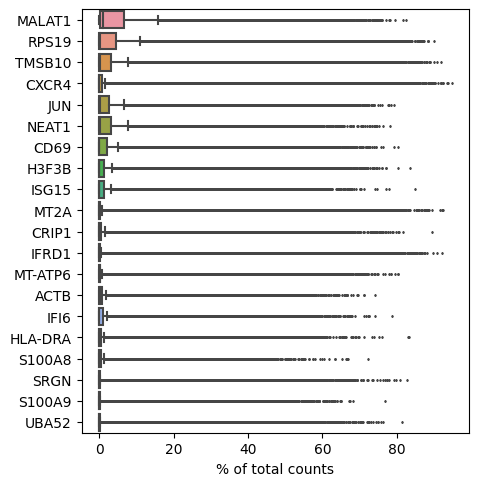

In [24]:
sc.pl.highest_expr_genes(pheno_adata, n_top=20, )


In [39]:
sc.pp.filter_cells(pheno_adata, min_genes=200)
sc.pp.filter_genes(pheno_adata, min_cells=3)

In [43]:
pheno_adata.var['mt'] = pheno_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(pheno_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

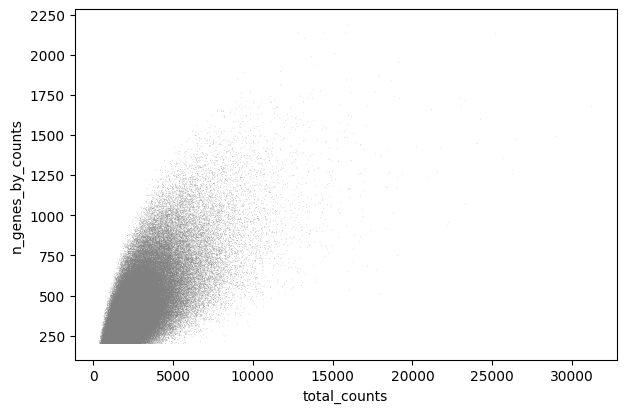

In [44]:
sc.pl.scatter(pheno_adata, x='total_counts', y='n_genes_by_counts')

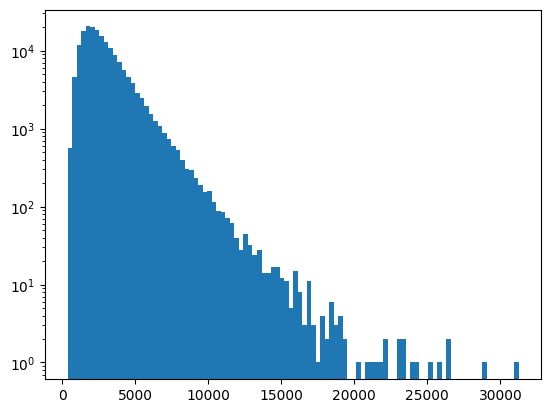

In [51]:
# filter cells with very low total counts?
plt.hist(pheno_adata.obs.total_counts, log=True, bins=100);

In [ ]:
pheno_exp_adata.layers['counts'] = pheno_exp_adata.X.copy()

sc.pp.normalize_total(pheno_exp_adata, target_sum=1e4)

In [ ]:
del pheno_exp_counts

In [ ]:
sc.pp.log1p(pheno_exp_adata)


In [ ]:
sc.pp.highly_variable_genes(pheno_exp_adata, min_mean=0.0125, max_mean=6, min_disp=0.5)
sc.pl.highly_variable_genes(pheno_exp_adata)


In [ ]:
pheno_exp_adata.raw = pheno_exp_adata
pheno_exp_adata.layers['lognorm'] = pheno_exp_adata.X.copy()


In [ ]:
sc.pp.scale(pheno_exp_adata, max_value=10)


In [ ]:
sc.tl.pca(pheno_exp_adata, svd_solver='arpack')


In [ ]:
sc.pl.pca(pheno_exp_adata, color='cell_type')


In [ ]:
sc.pl.pca_variance_ratio(pheno_exp_adata, log=True)


In [ ]:
sc.pp.neighbors(pheno_exp_adata, n_neighbors=10, n_pcs=20)


In [ ]:
sc.tl.umap(pheno_exp_adata)

In [ ]:
sc.pl.umap(pheno_exp_adata, color=['cell_type', 'group'], ncols=1)


In [ ]:
pheno_exp_adata.write_h5ad("/localdata/rna_rep_learning/scset/pheno_exp_adata.h5ad")

# Read back in adata

In [18]:
props_adata = sc.read_h5ad("/localdata/rna_rep_learning/scset/synthetic_props_exp/props_exp_adata.h5ad")

/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


## What distribution of cell type proportions did we end up with in our simulated data?

In [38]:
pt_celltype_props = pd.DataFrame(props_adata.obs.groupby(['patient','cell_type']).size()).rename(columns={0:"pt_ct_count"}).reset_index().merge(pd.DataFrame(props_adata.obs.groupby(['patient']).size()).rename(columns={0:"pt_count"}).reset_index())
pt_celltype_props['pt_ct_prop'] = pt_celltype_props.pt_ct_count / pt_celltype_props.pt_count
pt_celltype_props.head()

,patient,cell_type,pt_ct_count,pt_count,pt_ct_prop
0,sim1,B-cell,14,438,0.031963
1,sim1,T-cell,263,438,0.600457
2,sim1,monocytes,161,438,0.367580
3,sim2,B-cell,39,427,0.091335
4,sim2,T-cell,281,427,0.658080


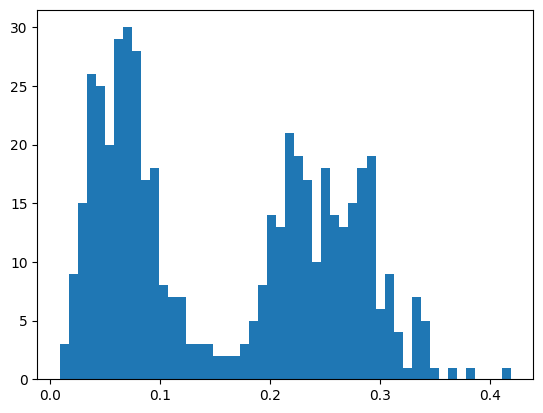

In [35]:
plt.hist(pt_celltype_props[pt_celltype_props.cell_type=="B-cell"].pt_ct_prop, bins=50);

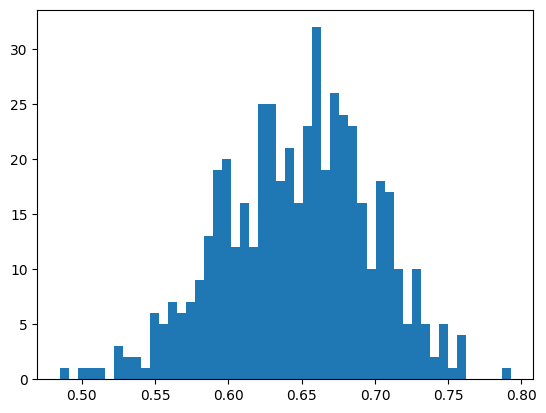

In [36]:
plt.hist(pt_celltype_props[pt_celltype_props.cell_type=="T-cell"].pt_ct_prop, bins=50);

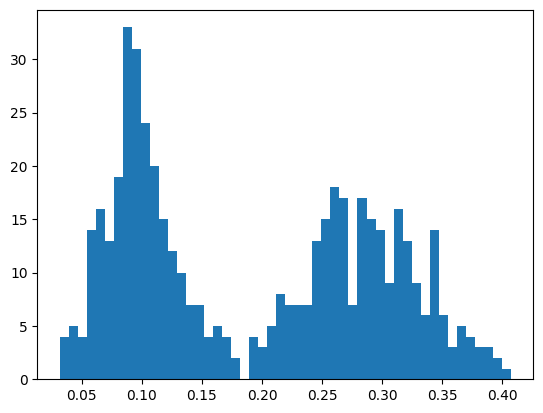

In [37]:
plt.hist(pt_celltype_props[pt_celltype_props.cell_type=="monocytes"].pt_ct_prop, bins=50);

/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


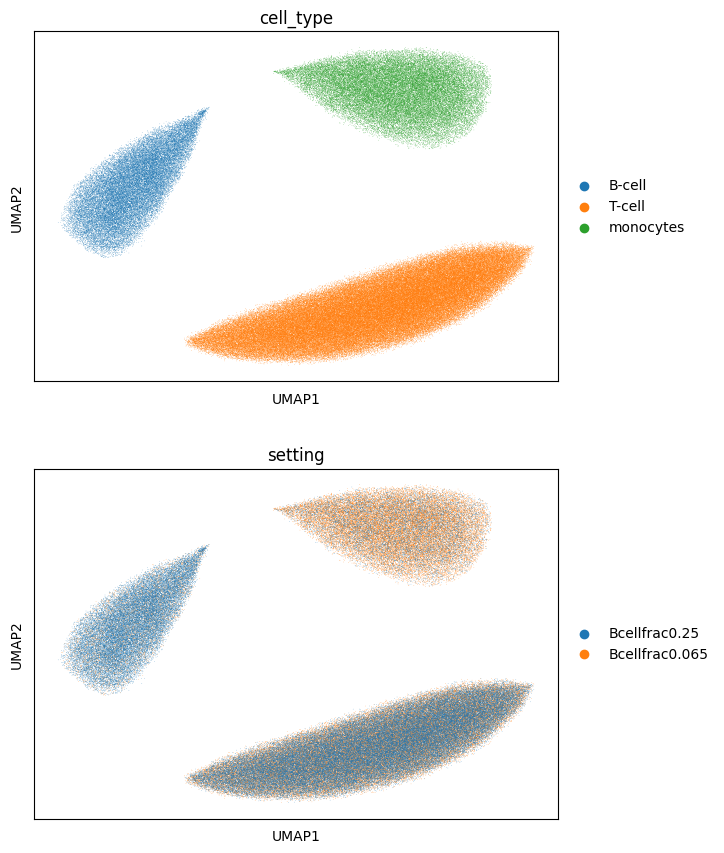

In [6]:
sc.pl.umap(props_adata, color=['cell_type', 'setting'], ncols=1)

In [31]:
pheno_adata = sc.read_h5ad("/localdata/rna_rep_learning/scset/synthetic_pheno_exp/pheno_exp_adata.h5ad")

KeyboardInterrupt: 

/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/rpeyser/envs/scset/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


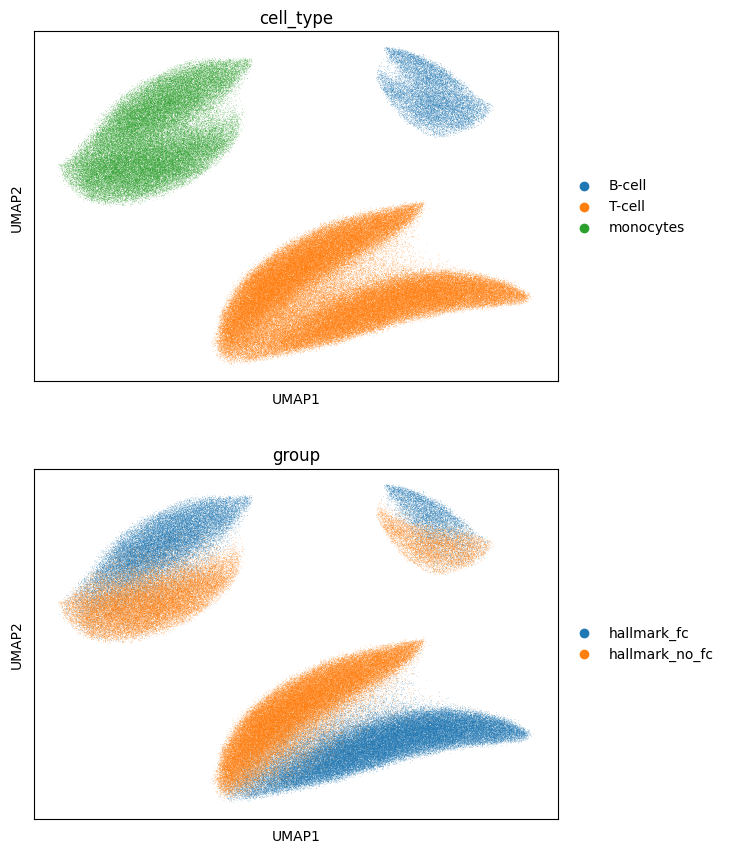

In [7]:
sc.pl.umap(pheno_adata, color=['cell_type', 'group'], ncols=1)

In [9]:
pheno_adata.obs

,cell_type,total_counts,patient,group
0,T-cell,766.039743,sim1,hallmark_fc
1,T-cell,4339.066309,sim1,hallmark_fc
2,T-cell,3854.111850,sim1,hallmark_fc
3,T-cell,788.100757,sim1,hallmark_fc
4,T-cell,627.730913,sim1,hallmark_fc
...,...,...,...,...
458,monocytes,8559.640169,sim500,hallmark_no_fc
459,monocytes,3924.985019,sim500,hallmark_no_fc
460,monocytes,3848.692150,sim500,hallmark_no_fc
461,monocytes,2204.530474,sim500,hallmark_no_fc


Text(0, 0.5, 'library size targets')

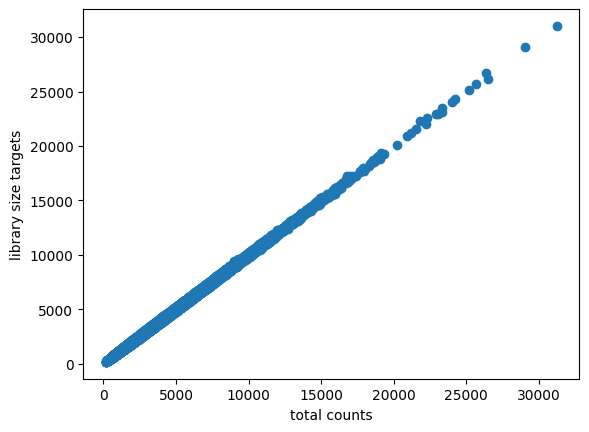

In [14]:
plt.scatter(pheno_adata.layers['counts'].sum(axis=1), pheno_adata.obs.total_counts)
plt.xlabel("total counts")
plt.ylabel("library size targets")

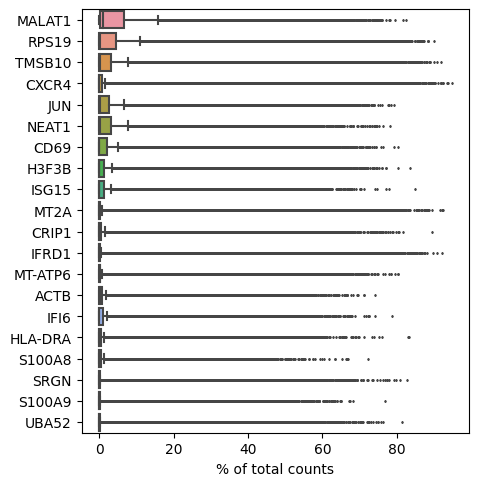

In [20]:
sc.pl.highest_expr_genes(sc.AnnData(pheno_adata.layers['counts'], var = pheno_adata.var), n_top=20, )


In [21]:
sc.pp.filter_cells(pheno_adata, min_genes=200)
sc.pp.filter_genes(pheno_adata, min_cells=3)

KeyboardInterrupt: 

In [ ]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

Text(0, 0.5, 'library size targets')

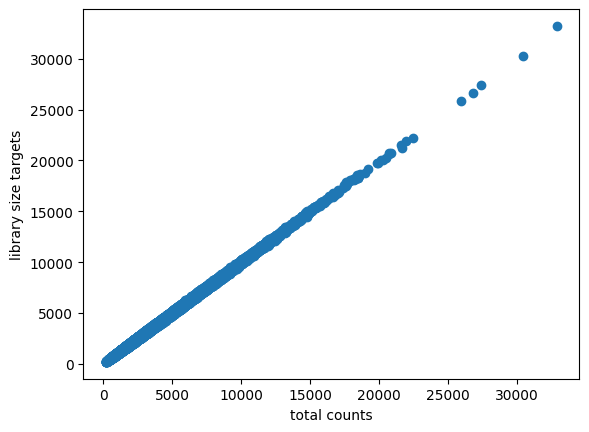

In [15]:
plt.scatter(props_adata.layers['counts'].sum(axis=1), props_adata.obs.total_counts)
plt.xlabel("total counts")
plt.ylabel("library size targets")

In [ ]:
# might want to remove cells with low library sizes in post processing

# Create a new proportions dataset with more subtle effect -- not obvious on pseudobulk

In [ ]:
cell_types = ["T-cell", "B-cell", "monocytes"]
cell_type_dirichlet_concentrations={"T-cell":0.65*100, "B-cell":0.065*100, "monocytes":0.284*100}
npatients = 500
mean_ncells = 445
total_cells_pp = scipy.stats.poisson.rvs(mean_ncells, size=npatients)
pheno_exp_counts = np.empty((np.sum(total_cells_pp), len(gene_params['T-cell'])))
verbose=False
timer = datetime.now()

cell_index = 0
for i in np.arange(npatients):
    if i> 0 and i % 10 == 0:
        print("generated {} patients in {}".format(i, datetime.now()-timer))
        timer = datetime.now()
    if i <=(npatients/2-1):    
        pheno_exp_counts[cell_index:cell_index+total_cells_pp[i],:], sample_metadata = simulate_patient_counts(cell_types, cell_type_concs=cell_type_dirichlet_concentrations, total_cells=total_cells_pp[i], gene_params=gene_params,
                                                                 loglibrary_mu=lib_log_mean, loglibrary_sigma=lib_log_std, pt_id="sim"+str(i+1),
                                                                 grouplabel="group", groupval="hallmark_fc", avg_perturb_fc=4, perturb_prob=0.8, perturbed_gene_set=cancer_genes,
                                                                 var_names=cd45_adata.var.index, verbose=verbose)
    else:
        pheno_exp_counts[cell_index:cell_index+total_cells_pp[i],:], sample_metadata = simulate_patient_counts(cell_types, cell_type_concs=cell_type_dirichlet_concentrations, total_cells=total_cells_pp[i], gene_params=gene_params,
                                                                 loglibrary_mu=lib_log_mean, loglibrary_sigma=lib_log_std, pt_id="sim"+str(i+1),
                                                                 grouplabel="group", groupval="hallmark_no_fc",
                                                                 var_names=cd45_adata.var.index, verbose=verbose)         
    cell_index += total_cells_pp[i]
    if i==0:
        pheno_exp_metadata = sample_metadata.copy()
    else: 
        pheno_exp_metadata = pd.concat([pheno_exp_metadata, sample_metadata], axis=0)


generated 10 patients in 0:00:22.116492
generated 20 patients in 0:00:21.735831
generated 30 patients in 0:00:21.489564
generated 40 patients in 0:00:21.393880
generated 50 patients in 0:00:21.771493
generated 60 patients in 0:00:21.733554
generated 70 patients in 0:00:21.612750
generated 80 patients in 0:00:21.339805
generated 90 patients in 0:00:21.706974
generated 100 patients in 0:00:21.595820
generated 110 patients in 0:00:21.600776
generated 120 patients in 0:00:21.833385
generated 130 patients in 0:00:22.024044
generated 140 patients in 0:00:22.106776
generated 150 patients in 0:00:22.227688
generated 160 patients in 0:00:21.346486
generated 170 patients in 0:00:21.675409
generated 180 patients in 0:00:21.866611
generated 190 patients in 0:00:33.046469
generated 200 patients in 0:00:45.043107
generated 210 patients in 0:00:45.512983
generated 220 patients in 0:00:46.932313
generated 230 patients in 0:00:47.126931
generated 240 patients in 0:00:46.397302
generated 250 patients in

In [ ]:
cell_types = ["T-cell", "B-cell", "monocytes"]
cell_type_dirichlet_conc_1 = {"T-cell":0.1*100, "B-cell":0.065*100, "monocytes":0.284*100}
cell_type_dirichlet_conc_2 = {"T-cell":0.2*100, "B-cell":0.065*100, "monocytes":0.284*100}

In [49]:
Tclust_assignments = pd.read_csv("zavidij_extras/fig2_T_cluster_assignments.csv")
Tclust_assignments = Tclust_assignments.set_index("Cell barcode").rename(columns={'Cell type':'Tcellsubtype'})
Tclust_assignments.head()

,Patient,Tcellsubtype
Cell barcode,,
CCTATTAAGTATTGGA-3,MM-1,CD4 Cytotoxic
GTAGGCCGTAACGCGA-9,MM-3,gamma-delta
AAGGAGCCAGCAGTTT-12,MM-4,Naive 3
AACACGTAGAACAATC-14,MM-5,gamma-delta
AAGTCTGGTTACCGAT-14,MM-5,gamma-delta


In [51]:
cd45_adata.obs = cd45_adata.obs.merge(Tclust_assignments[['Tcellsubtype']], how="left", right_index=True, left_index=True)

In [77]:
tcell_counts = pd.read_csv("zavidij_extras/fig2_T_counts.csv").rename(columns={'Unnamed: 0':'patient'}).set_index("patient").dropna()
tcell_counts.head()

,CD4 Cytotoxic,CD8 Cytotoxic,gamma-delta,Helper 1,Helper 2,IFN-responding,Memory Cytotoxic,Naive 1,Naive 2,Naive 3,NKT,T-reg
patient,,,,,,,,,,,,
NBM-1,1.0,2.0,3.0,13.0,0.0,0.0,10.0,0.0,3.0,2.0,0.0,0.0
NBM-2,0.0,2.0,8.0,85.0,0.0,4.0,31.0,64.0,16.0,9.0,1.0,1.0
NBM-3,1.0,0.0,0.0,1.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
NBM-4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0
NBM-5,2.0,1.0,0.0,48.0,1.0,3.0,24.0,28.0,8.0,10.0,0.0,0.0


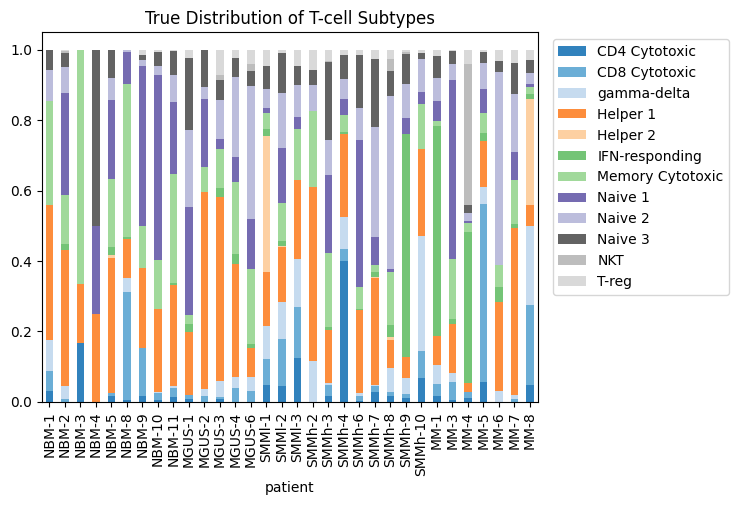

In [98]:
np.divide(tcell_counts.T, tcell_counts.sum(axis=1)).T.reset_index().plot(kind='bar', stacked=True, x="patient", colormap="tab20c")
plt.legend(loc="upper right", bbox_to_anchor=[0,0,1.4,1])
plt.title("True Distribution of T-cell Subtypes");

In [ ]:
#let's do memory cytotoxic, helper 1, cd4 and cd8, and alter the proportions of cd4 and cd8 between responders/non-responders

In [99]:
# save anndata to disk
cd45_adata.write_h5ad("/localdata/rna_rep_learning/zavidij_etal/cd45_adata.h5ad")